In [4]:
import labeled_functions
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors

import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cross_validation import cross_val_score, StratifiedKFold # Difference? (indices=None, or nothing)
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import keras
from keras.models import Model, save_model, load_model
from keras.layers import Dense, LSTM, Input, Embedding
from keras.utils import to_categorical
from keras.preprocessing.text import text_to_word_sequence, one_hot
from keras.preprocessing.sequence import pad_sequences

/Users/ekremguzelyel/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [5]:
X, y = labeled_functions.load_labeled_neutrals(path=r"./../../Fall_18/edu/active_learning/")

Labeled Data loaded.


In [6]:
# Vectorize using CountVectorizer
token = r"(?u)\b[\w\'/]+\b"
def vectorize(ngram=(1,3), stop=["the","a","of","and","br","to"]):
    return CountVectorizer(token_pattern=token, binary=True, ngram_range=ngram, stop_words=stop)

# X_train_corpus , X_test_corpus, y_train, y_test = train_test_split(X, y, test_size=1./3, random_state=42)

vectorizer_one = vectorize(stop=["a","of","and","br","to"])
X_vector = vectorizer_one.fit_transform(X)

# X_train_vector = vectorizer_one.fit_transform(X_train_corpus)
# X_test_vector = vectorizer_one.transform(X_test_corpus)

X_train_vector , X_test_vector, y_train, y_test = train_test_split(X_vector, y, test_size=1./3, random_state=42)

## LR and MNB

In [7]:
lr = LogisticRegression()
lr.fit(X_train_vector,y_train)
lr.score(X_test_vector,y_test)

0.6450381679389313

In [46]:
mnb = MultinomialNB(alpha=1, fit_prior=True)
mnb.fit(X_train_vector, y_train)
mnb.score(X_test_vector, y_test)

0.60431654676259

In [9]:
cv = StratifiedKFold(y, n_folds=5, random_state=42)

In [10]:
grams=[(1,1),(1,2),(1,3),(1,4)]

for gram in grams:
    print(gram)
    vectorizer = vectorize(ngram=gram, stop=["a","of","and","br","to"])
    X_vector = vectorizer.fit_transform(X)
    
    models = [LogisticRegression(), MultinomialNB()]
    
    for model in models:
        print(cross_val_score(model, X_vector, y, cv=cv, scoring="accuracy"))

(1, 1)
[0.61887477 0.62216167 0.62181818 0.65423112 0.59872611]
[0.60707804 0.60127157 0.59454545 0.61419472 0.58871702]
(1, 2)
[0.64700544 0.63215259 0.63545455 0.65969063 0.63967243]
[0.6107078  0.61126249 0.61090909 0.62056415 0.61237489]
(1, 3)
[0.6415608  0.62306994 0.63       0.6633303  0.62966333]
[0.6061706  0.60490463 0.61454545 0.62693358 0.61419472]
(1, 4)
[0.63883848 0.626703   0.62454545 0.66969973 0.633303  ]
[0.6061706  0.61217075 0.62090909 0.62602366 0.61510464]


#### IMPORTANT! 
I had to go back and check the document if they are labeled correctly, due to lower accuracies in all LR, MNB, and LSTM models. Look below cell for the coefficients in LR. 

They make no sense in other than n_gram = (1,1)

In [11]:
lr.coef_.shape

(3, 68586)

In [12]:
lr.classes_

array([-1,  0,  1])

In [47]:
vectorizer=vectorize(ngram=(1,3), stop=["a","of","and","br","to"])
X_vector = vectorizer.fit_transform(X)

X_train_vector , X_test_vector, y_train, y_test = train_test_split(X_vector, y, test_size=1./3, random_state=42)

lr.fit(X_train_vector,y_train)
print(lr.score(X_test_vector,y_test))

# Find biggest coefficients.

for i in range(3):
    print(lr.classes_[i])
    

    inds = np.argsort(np.abs(lr.coef_[i]))[::-1]

    print(inds)
    
    for j in inds[:20]:
        print("%s \t %0.2f" %(vectorizer.get_feature_names()[j], lr.coef_[i][j]))
    
    print()

#coefs = list(zip(vectorizer.get_feature_names(), np.abs(lr.coef_[0])))
#rank_coefs = sorted(coefs, key = lambda x: x[1], reverse=True)
#rank_coefs[:50]

0.6181516325401217
-1
[ 8601  5093  6499 ... 26701 26702     0]
boring 	 2.17
awful 	 2.02
beautiful 	 -1.70
waste 	 1.67
great 	 -1.65
worst 	 1.64
dull 	 1.61
rare 	 -1.54
fails 	 1.52
not bad 	 -1.51
pointless 	 1.40
excellent 	 -1.39
best 	 -1.36
not 	 1.36
stupid 	 1.36
loved 	 -1.34
fantastic 	 -1.34
ridiculous 	 1.32
fun 	 -1.29
predictable 	 1.28

0
[20327  8601 45758 ... 42223 16541     0]
friend 	 1.65
boring 	 -1.35
rarely 	 1.30
best friend 	 1.19
beloved 	 1.15
after 	 1.12
unsurprisingly 	 1.09
him 	 1.04
awful 	 -1.04
funeral 	 0.99
can not 	 0.97
vampire 	 0.97
his 	 0.95
7/10 	 -0.95
unpredictable 	 0.95
surprisingly 	 0.95
the bad 	 0.95
bad guy 	 0.95
amazing 	 -0.95
dull 	 -0.94

1
[44187 39765   343 ... 46506 18822     0]
poor 	 -2.16
not bad 	 2.02
7/10 	 2.00
excellent 	 1.99
great 	 1.85
amazing 	 1.77
enjoyable 	 1.71
8/10 	 1.69
beautiful 	 1.67
bad 	 -1.60
perfectly 	 1.53
fantastic 	 1.52
unfortunately 	 -1.46
fun 	 1.44
perfect 	 1.36
wonderful 	 1.35
loved

In [12]:
inds

array([38759, 43080,  6337, ..., 31992, 31993,     0])

In [21]:
for c in [0.01, 0.1, 1, 10, 100]:
    lr = LogisticRegression(C=c, penalty='l1')
    lr.fit(X_train_vector,y_train)
    print(c)
    print(lr.score(X_train_vector, y_train))
    print(lr.score(X_test_vector, y_test))
    print()

0.01
0.36083068935679263
0.3817762399077278

0.1
0.5471589270262475
0.5357554786620531

1
0.8422267089702913
0.6291810841983853

10
0.9979809633689068
0.621683967704729

100
0.9979809633689068
0.6153402537485583



In [13]:
from sklearn.feature_selection import mutual_info_classif

In [14]:
mis = mutual_info_classif(X_train_vector, y_train, discrete_features=True)
inds = np.argsort(mis)[::-1]

for j in inds[:20]:
    print("%s \t %0.4f" %(vectorizer.get_feature_names()[j], mis[j]))

are wonderful the 	 0.0184
back this episode 	 0.0149
disentangling themselves from 	 0.0147
art did not 	 0.0141
even divison 	 0.0134
mr kennedy in last 	 0.0133
mr cage 	 0.0130
awfulness the film 	 0.0124
endlessly arguing about 	 0.0117
one case really bad 	 0.0110
is mediocre at 	 0.0105
his two role 	 0.0094
funny then i 	 0.0088
much at one 	 0.0079
are probably 	 0.0074
going after 	 0.0073
film has aged poorly 	 0.0068
i must declare this 	 0.0063
remains among the high 	 0.0060
at her husband 	 0.0058


## LSTM
Change labels to_categorical to use neutrals, convert corpus into sequences, pad, and train.

In [9]:
y_cat = to_categorical(y,num_classes=3)
y_cat[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [10]:
X_sequence = []
for i in X:
    X_sequence.append(text_to_word_sequence(i))
X_train_sequence, X_test_sequence, y_train, y_test = train_test_split(X_sequence, y_cat, test_size=1./3, random_state=42)

X_train_sequence[0], y_train[0]

(['this', 'was', 'funny'], array([0., 1., 0.], dtype=float32))

_From My Older Notes:_

Here is why this code doesn't work:
 - We are trying to first convert the corpus into sequence, which is a list, then, try to one_hot encode.
 - What we should do is use corpus and one_hot encode directly from text. Which is the _below_ row.

In [11]:
# Maximum sequence length
max_length = len(max(X_sequence,key=len))
max_length

134

In [12]:
X_corpus_one_hot = []
for i in X:
    X_corpus_one_hot.append(one_hot(i, round(max_length*1.1)))

X_corpus_one_hot[4:7]

[[118, 124, 111, 114, 3, 124, 67, 40, 54, 119, 126, 54, 68, 125],
 [83, 127, 92, 66, 53, 120],
 [42, 80, 98, 91, 34, 89, 114]]

In [13]:
padded_seq = pad_sequences(X_corpus_one_hot)
X_train_padded_seq, X_test_padded_seq, y_train, y_test = train_test_split(padded_seq, y_cat,
                                                                          test_size=1./3, random_state=42)

In [14]:
X_train_padded_seq.shape, X_test_padded_seq.shape, y_cat.shape

((3467, 134), (1734, 134), (5201, 3))

In [15]:
# Model setup
input_nodes= Input(shape=(X_train_padded_seq.shape[1],))
e = Embedding(round(max_length*1.1),
              32,
              input_length=X_train_padded_seq.shape[1],
              trainable=True)(input_nodes)
lstm=LSTM(20, return_sequences=True)(e)
lstm=LSTM(10)(lstm)
output_nodes=Dense(3, activation='softmax')(lstm)

#Build model
model = Model(inputs=input_nodes, outputs=output_nodes)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Creating validation data 
X_test_core, X_val, y_test_core, y_val = train_test_split(X_test_padded_seq, y_test, test_size=0.2, random_state=42)

In [17]:
model.fit(X_train_padded_seq, y_train, batch_size=64, epochs=50, validation_data=(X_val,y_val))

Train on 3467 samples, validate on 347 samples
Epoch 1/50
3467/3467 [==============================] - 12s 4ms/step - loss: 1.0960 - acc: 0.3585 - val_loss: 1.0801 - val_acc: 0.4150
Epoch 2/50
3467/3467 [==============================] - 11s 3ms/step - loss: 1.0763 - acc: 0.4001 - val_loss: 1.0426 - val_acc: 0.4957
Epoch 3/50
3467/3467 [==============================] - 11s 3ms/step - loss: 1.0348 - acc: 0.4580 - val_loss: 1.0536 - val_acc: 0.4582
Epoch 4/50
3467/3467 [==============================] - 11s 3ms/step - loss: 1.0049 - acc: 0.4857 - val_loss: 1.0194 - val_acc: 0.4669
Epoch 5/50
3467/3467 [==============================] - 11s 3ms/step - loss: 0.9833 - acc: 0.5065 - val_loss: 1.0107 - val_acc: 0.4870
Epoch 6/50
3467/3467 [==============================] - 11s 3ms/step - loss: 0.9663 - acc: 0.5293 - val_loss: 1.0030 - val_acc: 0.4899
Epoch 7/50
3467/3467 [==============================] - 11s 3ms/step - loss: 0.9599 - acc: 0.5290 - val_loss: 1.0185 - val_acc: 0.4928
Epoch 8/

In [18]:
model.evaluate(X_test_core, y_test_core)

1387/1387 [==============================] - 1s 847us/step


[1.2180540485182683, 0.4873828407277628]

In [19]:
preds = model.predict(X_test_core)
preds

array([[9.9610549e-01, 7.7365612e-04, 3.1208701e-03],
       [6.3733304e-01, 1.9509244e-01, 1.6757455e-01],
       [3.4933180e-01, 1.3043586e-02, 6.3762456e-01],
       ...,
       [9.8886907e-01, 5.0420724e-03, 6.0888818e-03],
       [2.4464671e-02, 9.6836251e-01, 7.1728053e-03],
       [1.0649871e-01, 8.2648814e-01, 6.7013212e-02]], dtype=float32)

_Strategies to Classify:_

__Does positive and negative predictions being similar mean "Neutral"?__ Possibly, but there are a lot of cases where it doesn't.

__If neutral classification is less than 40%, can we infer that it's not neutral?__

In [20]:
def get_sample(n,k):
#     return X[n:k], y_test_core[n:k], y_cat[n:k], preds[n:k]
    return y_test_core[n:k], preds[n:k]
get_sample(35,39)

(array([[0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], dtype=float32),
 array([[0.19020031, 0.6188789 , 0.19092086],
        [0.8100225 , 0.00754798, 0.18242958],
        [0.12360615, 0.78871316, 0.08768073],
        [0.24501356, 0.55131865, 0.20366777]], dtype=float32))

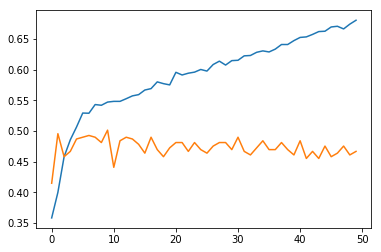

In [21]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.show()

In [22]:
with open(r"100epoch", "rb") as input_file:
    model100_hist = pickle.load(input_file)

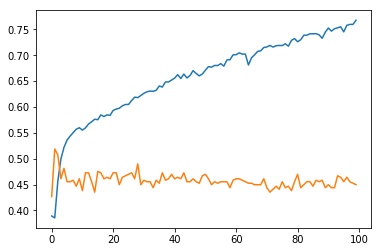

In [23]:
plt.plot(model100_hist['acc'])
plt.plot(model100_hist['val_acc'])
plt.show()

## ACTION PLAN:

Learn about combining two models.
- It occured to me that some keywords are so much likely to be aligned with the category of an EDU.
- However, there are still 80% that doesn't fall into this category. 
- For those which are ambigious, train a sequence model and train deeper. 
- Combine 20% weights with the rest 80%

Re-evaluate LabeledEDUs.
- I found significant flaws in labeling. 
- Go over keyword by keyword until you think it's a good bag.

Learn more about lingustics.
- I realized that suffixes change the meaning a lot. 
- Check adverbs, adjectives, verbs in grammar context.
- Find a paper to distinguish between the parts of speech.

Approach differently.
- Pull a list of adverbs, adjectives, verbs, conjunctions, etc.
    - https://www.aims.edu/student/online-writing-lab/grammar/parts-of-speech.php
- Train on those lists.


__Note to myself:__ Nouns, verbs, and adverbs, if they have no meaning of an _adjective_ by themselves, they are likely to give clue about the category of the word.

Past tense is also an indication of a first person review.

Example: poorly, loved, (find more here)